IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

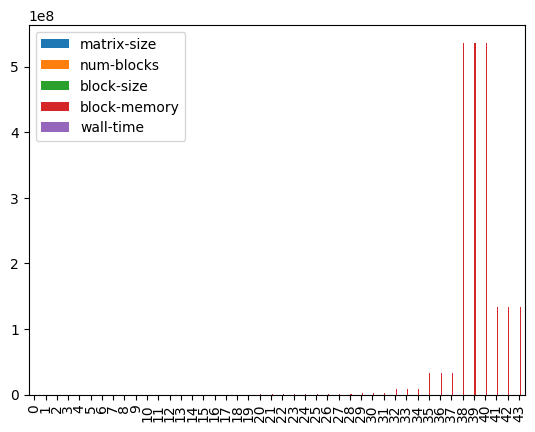

In [ ]:
from typing import List, Optional, Any
import matplotlib.pyplot as plt
import matplotlib.axes
import matplotlib.container
import matplotlib.figure
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

df = pd.read_csv('measurement2.csv')

df

df.plot(kind='bar')

plt.xlabel(df["scheduler"])

# plt.show()

# grouped = df.groupby(df.columns[3]).size()
# grouped.plot(kind='bar')
# plt.xlabel(df.columns[3])
# plt.ylabel('Count')
# plt.title('Bar Chart Grouped by {}'.format(df.columns[4]))
# plt.show()
